In [1]:
### we need to import the pandas and numpy (essential libraries)
import pandas as pd
import numpy as np
### Import data visualization packages 
import matplotlib.pyplot as plt 
import seaborn as sns 
import altair as alt 
### import preprocessing packages
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score ### needed to create training and testing datasets 
from sklearn.impute import SimpleImputer, KNNImputer ### need to impute the data 
from sklearn.preprocessing import StandardScaler, OneHotEncoder ### need to standarize and scale the data correctly 
from sklearn.compose import ColumnTransformer ### this is needed to create the pipeline 
from sklearn.pipeline import Pipeline ### this will create the pipeline 
from sklearn.tree import DecisionTreeClassifier, plot_tree , DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report , accuracy_score, recall_score, precision_recall_curve,precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
################################################################################
################################################################################
#                       Start of Preprocessing                                 #
################################################################################
################################################################################
## set a random seed 
random_seed = 172193
np.random.seed(random_seed)
df = pd.read_excel('Employee_Data_Project.xlsx')
target = 'Attrition'
drop = ['EmployeeID' , 'StandardHours']
num_vars = ['Age' , 'DistanceFromHome' , 'Income' , 'NumCompaniesWorked' , 'TotalWorkingYears' , 'TrainingTimesLastYear'
            , 'YearsAtCompany' , 'YearsWithCurrManager']
ordinal_vars = ['Education' , 'JobLevel' , 'EnvironmentSatisfaction' , 'JobSatisfaction']
nom_vars = ['Gender' , 'BusinessTravel' , 'MaritalStatus']
df['Attrition_lab'] = df['Attrition'].map({'Yes':1 , 'No' :0})
X = df[num_vars+ordinal_vars+nom_vars].copy()
y= df['Attrition_lab'].copy()
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=random_seed)
## need to transform the numeric columns, nominal and ordinal columns 
### KNN imputation for the numerical columns
numeric_imputation = Pipeline(steps = [(
    'imputer' , KNNImputer(n_neighbors=5 , weights='uniform')),
('scaler' , StandardScaler())])
### regarding the nominal variables , use onehotencoding and replace the nulls with the mode (most frequent)
nominal_imputation = Pipeline(steps=[(
'imputer' , SimpleImputer(strategy= 'most_frequent')),
('one_hot_encoder' , OneHotEncoder(handle_unknown= 'ignore' , sparse_output= False , drop = 'first'))])
### regarding the ordinal variables replace with the median 
ordinal_imputation = Pipeline(steps= [('imputer' , SimpleImputer(strategy='median'))])
pre_process = ColumnTransformer(transformers=[('numeric' , numeric_imputation , num_vars),
                                              ('ordinal' , ordinal_imputation, ordinal_vars),
                                              ('nominal' , nominal_imputation , nom_vars)])
X_train_processed = pre_process.fit_transform(X_train)  
X_test_processed = pre_process.transform(X_test)
feature_names = pre_process.get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns= feature_names)
### during the preprocessing pipeline , was converted to a np.array 
### convert to np.array to match X_train_processed

y_train_arr = y_train.values
pos_idx = np.where(y_train_arr == 1)[0]
neg_idx = np.where(y_train_arr == 0 )[0]

#### set randomseed again 
np.random.seed(random_seed)
keep_neg= np.random.choice(neg_idx, size = len(pos_idx), replace = False)
keep_idx = np.concatenate([pos_idx, keep_neg])

y_train_balanced = y_train_arr[keep_idx]
X_train_balanced = X_train_processed[keep_idx]

y_train_balanced_df = pd.DataFrame(y_train_balanced , columns= ['Attrition_lab'])
X_train_processed_balanced_df = pd.DataFrame(X_train_balanced , columns = feature_names)

################################################################################
################################################################################
#                             End of preprocessing                             #
################################################################################
################################################################################

---

#### complex Model -- balanced

In [2]:

pipe = DecisionTreeClassifier(random_state=random_seed)
param_grid = {"ccp_alpha" : np.arange(0.001, 0.101, 0.01)}
grid = GridSearchCV(
    estimator=pipe, 
    param_grid=param_grid,
    scoring= 'roc_auc',
    cv = 10, 
    n_jobs = -1)
grid.fit(X_train_processed_balanced_df, y_train_balanced)
print("Best params:", grid.best_params_)
print("Best mean CV ROC AUC:", grid.best_score_)
best_tree = grid.best_estimator_
cv_results = pd.DataFrame(grid.cv_results_)



Best params: {'ccp_alpha': np.float64(0.001)}
Best mean CV ROC AUC: 0.8431187755102041


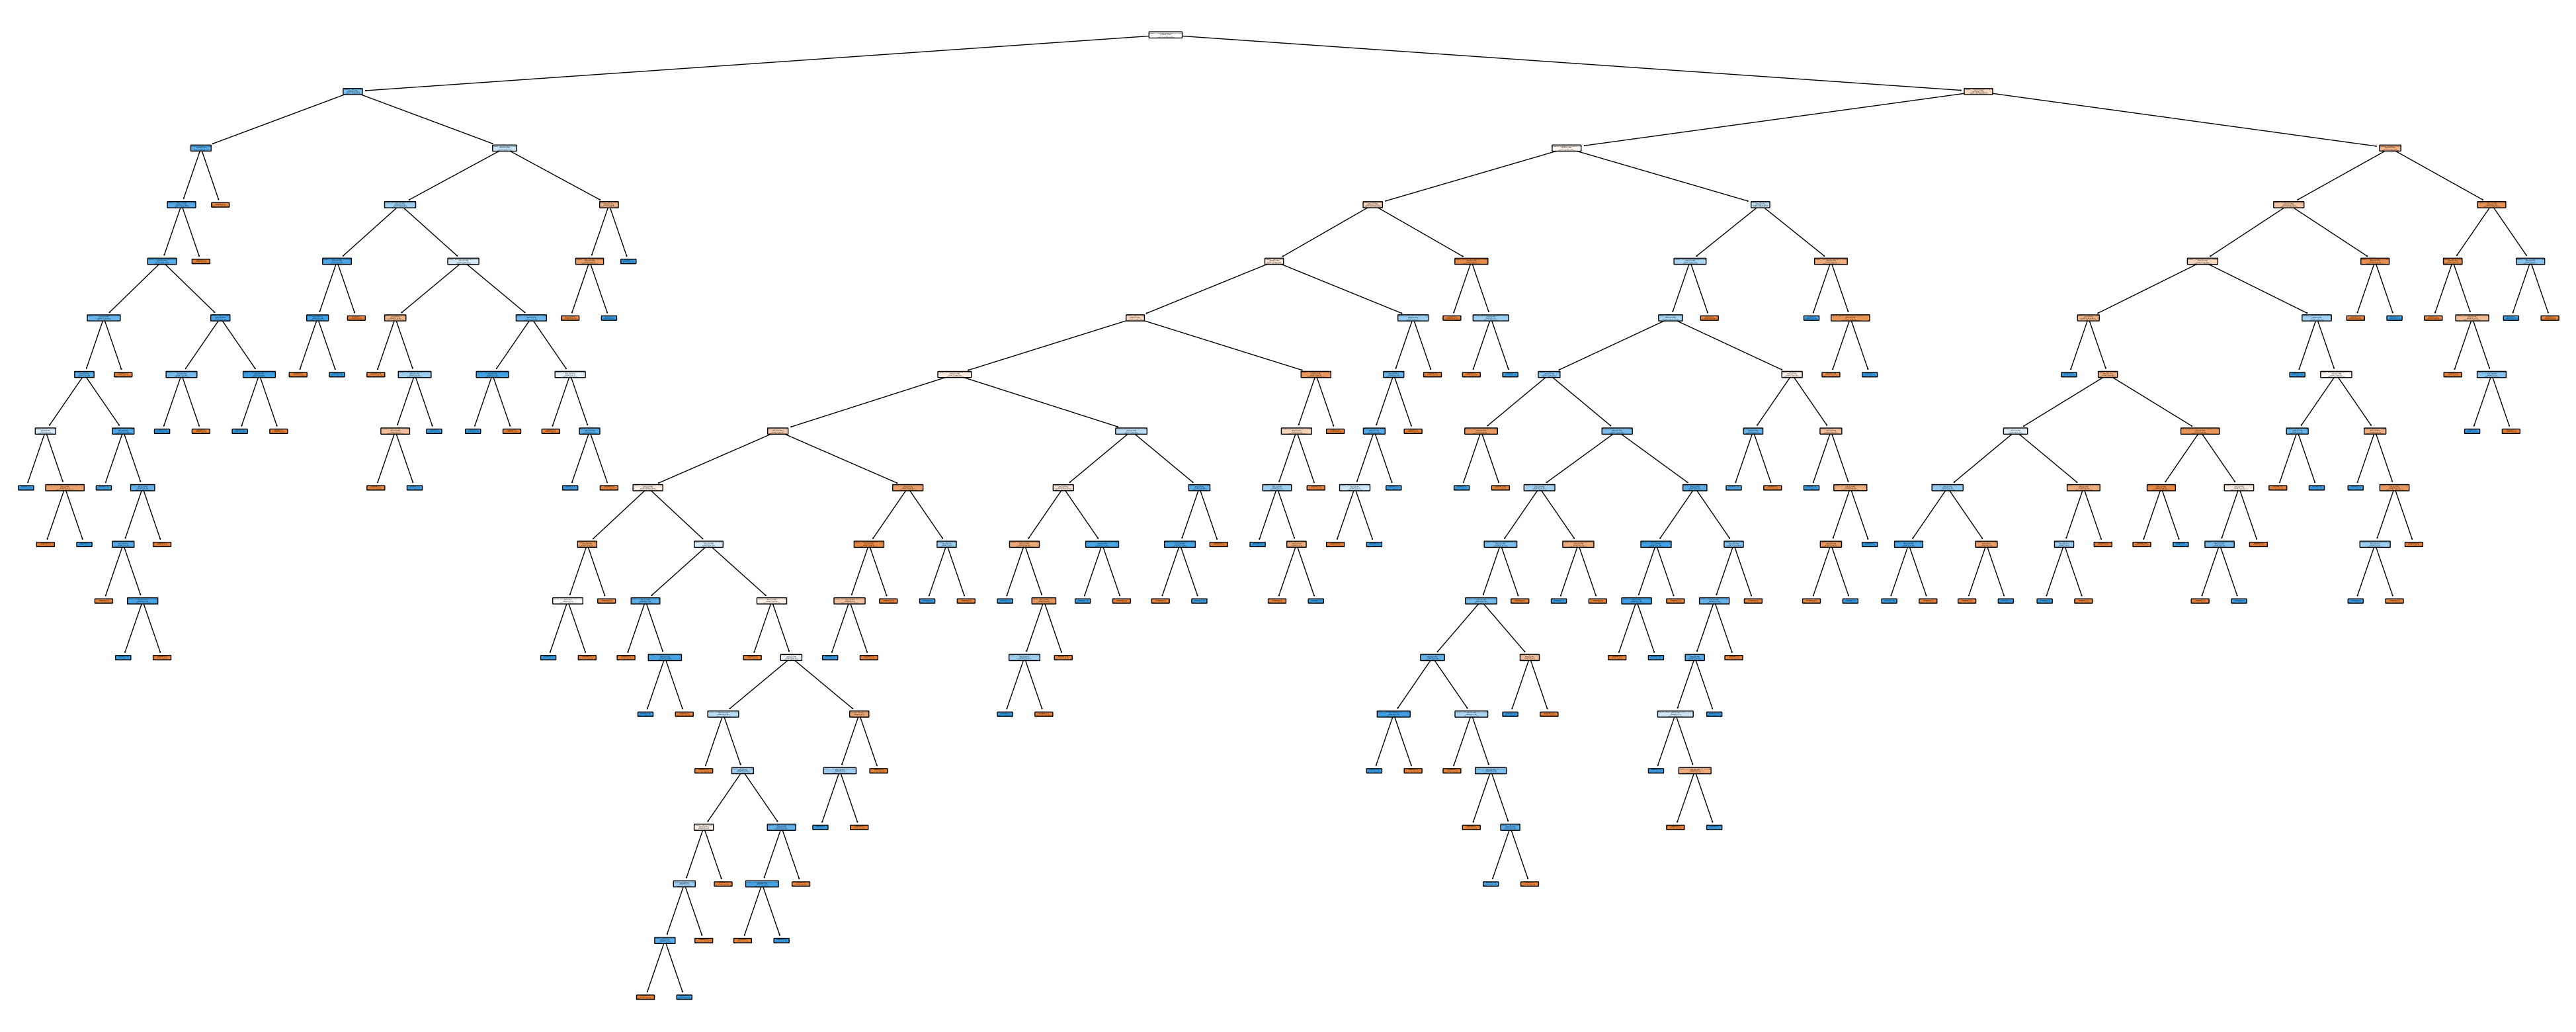

In [3]:
plt.figure(figsize=(50,20))
plot_tree(
    best_tree,
    feature_names = X_train_processed_balanced_df.columns.tolist(),
    class_names = ['No Attrition (0)' , 'Attrition (1)'],
    filled = True , 
    rounded = True
)
plt.show()

In [4]:
### get in-sample ROC curve and AUC 

probs = best_tree.predict_proba(X_train_processed_balanced_df)
true_idx = np.where(best_tree.classes_ ==1 )[0][0]
probs_true = probs[:, true_idx]
train_fpr , train_tpr , train_tresholds = roc_curve( y_train_balanced , probs_true)
train_auc_value = roc_auc_score(y_train_balanced , probs_true)
print("\nTrain ROC AUC for Attrition:", train_auc_value)


Train ROC AUC for Attrition: 0.9970645634747827


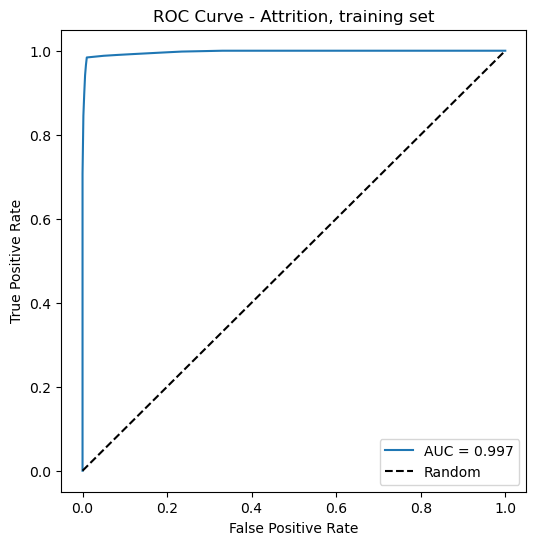

In [5]:
plt.figure(figsize=(6, 6))
plt.plot(train_fpr, train_tpr, label=f"AUC = {train_auc_value:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Attrition, training set")
plt.legend(loc="lower right")
plt.show()


Variable Importance: numeric__Income                              0.141581
numeric__Age                                 0.129902
numeric__DistanceFromHome                    0.123957
numeric__YearsWithCurrManager                0.096780
numeric__TotalWorkingYears                   0.094371
numeric__YearsAtCompany                      0.081108
numeric__TrainingTimesLastYear               0.064083
ordinal__EnvironmentSatisfaction             0.063919
numeric__NumCompaniesWorked                  0.055091
ordinal__JobSatisfaction                     0.040004
ordinal__Education                           0.028608
nominal__MaritalStatus_Single                0.028003
ordinal__JobLevel                            0.025551
nominal__BusinessTravel_Travel_Frequently    0.013816
nominal__BusinessTravel_Travel_Rarely        0.006889
nominal__MaritalStatus_Married               0.006336
nominal__Gender_Male                         0.000000
dtype: float64


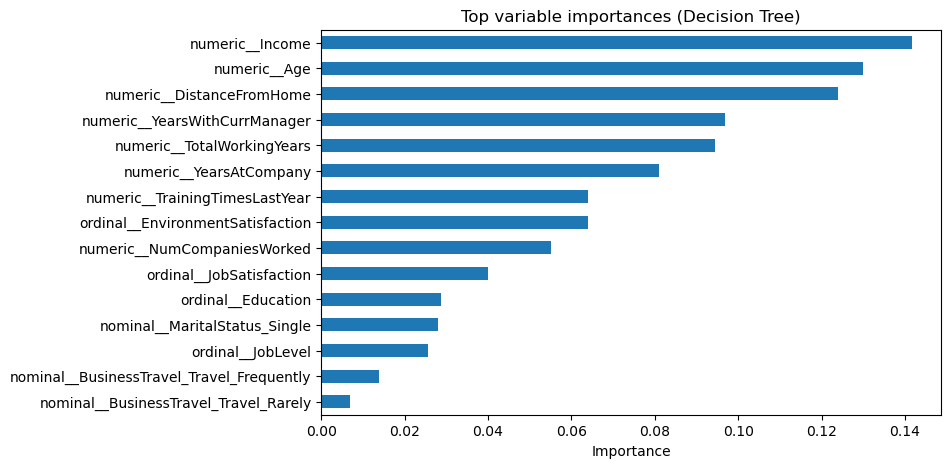

In [6]:
## Variable Importance: 
importances = pd.Series(
    best_tree.feature_importances_,
    index = X_train_processed_balanced_df.columns).sort_values(ascending=False)
print(f'\nVariable Importance: {importances}')
plt.figure(figsize=(8,5))
importances.head(15).plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title("Top variable importances (Decision Tree)")
plt.xlabel("Importance")
plt.show()

In [7]:
### Look at two most important variables together ----

top_two = importances.head(2).index.tolist()
print("\nTop two variables:", top_two)


Top two variables: ['numeric__Income', 'numeric__Age']


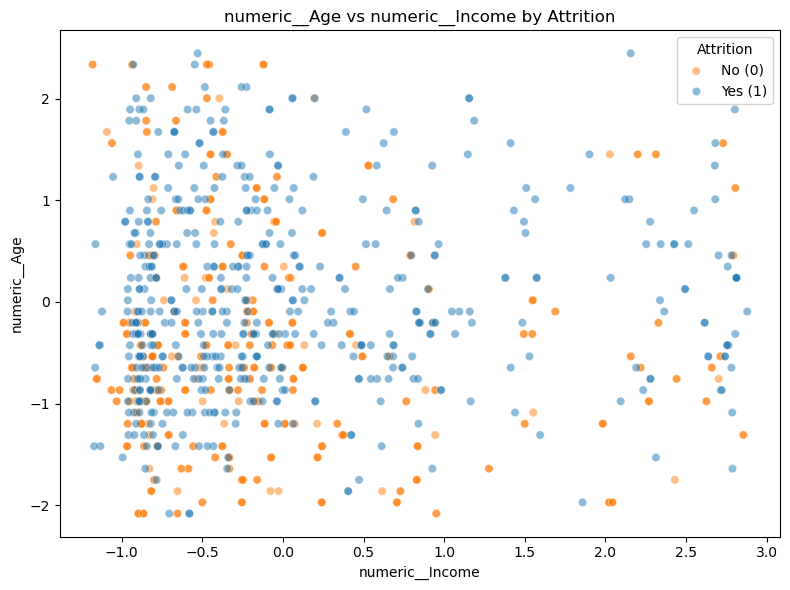

In [8]:
## create a dataset for plotting 

if len(top_two) == 2:
    var_x, var_y = top_two
    data_two_plot = X_train_processed_balanced_df.copy()
    data_two_plot['Attrition_lab'] = y_train_balanced
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data = data_two_plot,
        x=var_x,
        y=var_y,
        hue="Attrition_lab",
        alpha=0.5
    )
    plt.title(f"{var_y} vs {var_x} by Attrition")
    plt.legend(title = 'Attrition' , labels = ['No (0)' , 'Yes (1)'])
    plt.tight_layout()
    plt.show()

In [9]:
## predictions and the final model evaulation on the test set 

probs_test = best_tree.predict_proba(X_test_processed_df)
probs_true_test = probs_test[:, true_idx]
## get the ROC and the AUC for the test set 

test_fpr , test_tpr , test_thresholds = roc_curve(y_test, probs_true_test) 
test_auc_value = roc_auc_score(y_test, probs_true_test)

print(f'\nTst ROC AUC for Attrition: {test_auc_value}')



Tst ROC AUC for Attrition: 0.8613479676859958


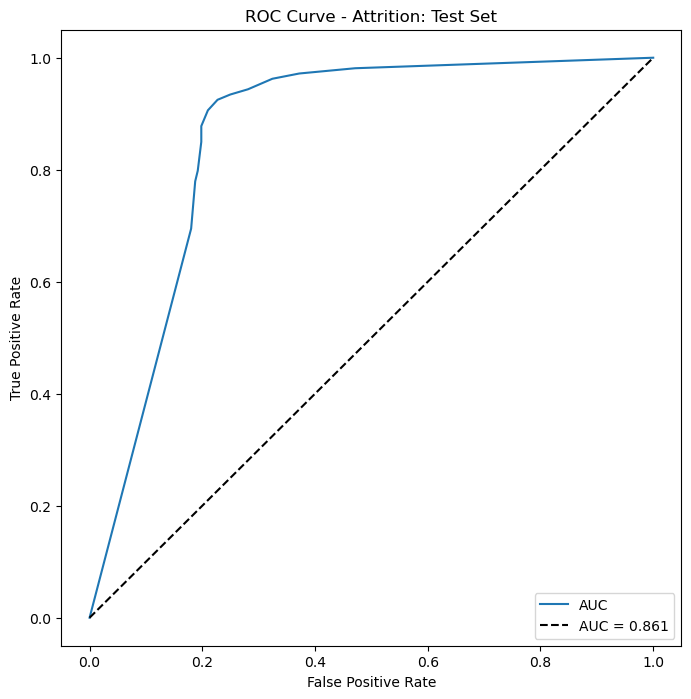

In [10]:
#### now we need to plot the ROC AUC curve

plt.figure(figsize=(8,8))
plt.plot(test_fpr , test_tpr , label = 'AUC')
plt.plot([0,1],[0,1], 'k--' , label=f"AUC = {test_auc_value:.3f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Attrition: Test Set')
plt.legend(loc='lower right')
plt.show()


In [11]:
### Generate preditions at a 0.5 threshold 
y_pred_test = (probs_true_test > 0.5).astype(int)
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
print(f'Test Set -- Accuracy: {accuracy_test} , Recall: {recall_test} , Precision: {precision_test} , f1: {f1_test}')


Test Set -- Accuracy: 0.8087679516250945 , Recall: 0.9061032863849765 , Precision: 0.45305164319248825 , f1: 0.6040688575899843


In [12]:
cm_test = confusion_matrix(y_test, y_pred_test)
print(f'\nConfusion Matrix')
print(cm_test)


Confusion Matrix
[[877 233]
 [ 20 193]]


In [13]:
cr_test = classification_report(y_test, y_pred_test , target_names = ['No Attrition (0)'  , 'Attrition (1)'])
print(f'\nClassification Report')
print(cr_test)


Classification Report
                  precision    recall  f1-score   support

No Attrition (0)       0.98      0.79      0.87      1110
   Attrition (1)       0.45      0.91      0.60       213

        accuracy                           0.81      1323
       macro avg       0.72      0.85      0.74      1323
    weighted avg       0.89      0.81      0.83      1323



---

complex model -- unbalanced

In [14]:
pipe1 = DecisionTreeClassifier(random_state=random_seed)
param_grid1 = {"ccp_alpha" : np.arange(0.001, 0.101, 0.01)}
grid1 = GridSearchCV(
    estimator=pipe1, 
    param_grid=param_grid1,
    scoring= 'roc_auc',
    cv = 10, 
    n_jobs = -1)
grid1.fit(X_train_processed_df, y_train)
print("Best params:", grid1.best_params_)
print("Best mean CV ROC AUC:", grid1.best_score_)
best_tree1 = grid1.best_estimator_
cv_results1 = pd.DataFrame(grid1.cv_results_)



Best params: {'ccp_alpha': np.float64(0.001)}
Best mean CV ROC AUC: 0.8511484947215845


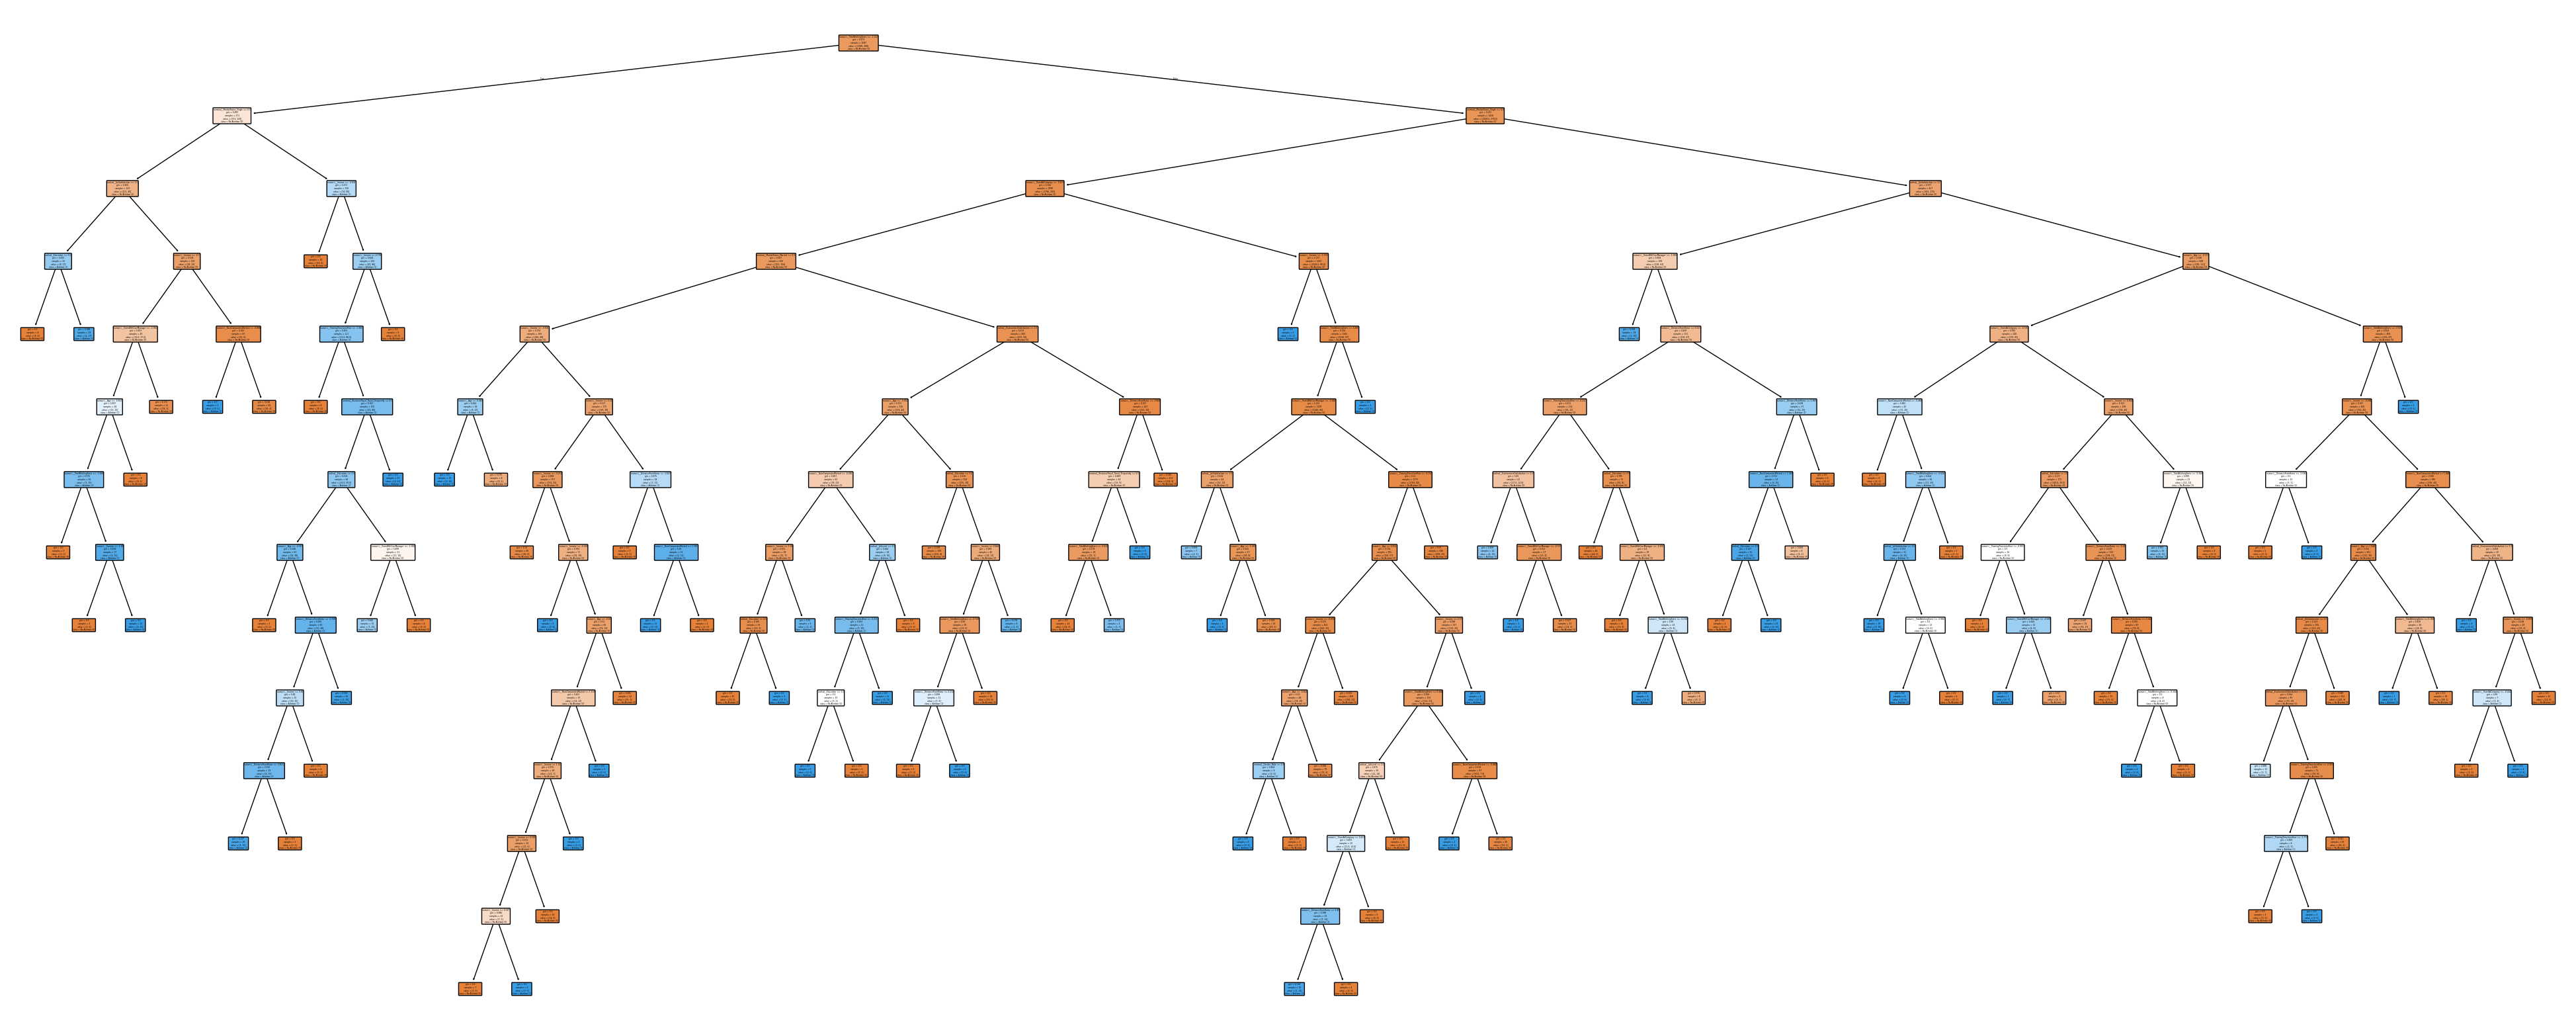

In [15]:
plt.figure(figsize=(50,20))
plot_tree(
    best_tree1,
    feature_names = X_train_processed_df.columns.tolist(),
    class_names = ['No Attrition (0)' , 'Attrition (1)'],
    filled = True , 
    rounded = True
)
plt.show()


In [16]:
### get in-sample ROC curve and AUC 

probs1 = best_tree1.predict_proba(X_train_processed_df)
true_idx1 = np.where(best_tree1.classes_ ==1 )[0][0]
probs_true1 = probs1[:, true_idx1]
train_fpr1 , train_tpr1 , train_tresholds1 = roc_curve( y_train , probs_true1)
train_auc_value1 = roc_auc_score(y_train , probs_true1)
print("\nTrain ROC AUC for Attrition:", train_auc_value1)



Train ROC AUC for Attrition: 0.927256728730294


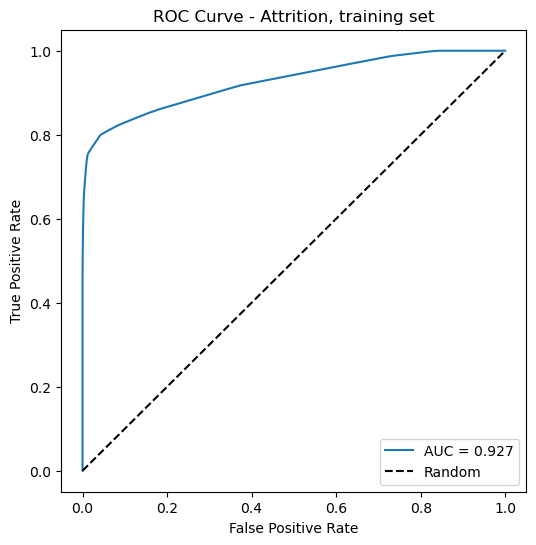

In [17]:
plt.figure(figsize=(6, 6))
plt.plot(train_fpr1, train_tpr1, label=f"AUC = {train_auc_value1:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Attrition, training set")
plt.legend(loc="lower right")
plt.show()


Variable Importance: numeric__TotalWorkingYears                   0.186513
numeric__Income                              0.167502
numeric__DistanceFromHome                    0.107264
numeric__Age                                 0.082087
numeric__YearsWithCurrManager                0.058673
numeric__NumCompaniesWorked                  0.058152
ordinal__Education                           0.057994
ordinal__JobSatisfaction                     0.052882
nominal__MaritalStatus_Single                0.052403
numeric__TrainingTimesLastYear               0.046010
numeric__YearsAtCompany                      0.045030
ordinal__EnvironmentSatisfaction             0.040329
nominal__BusinessTravel_Travel_Frequently    0.016333
ordinal__JobLevel                            0.013876
nominal__MaritalStatus_Married               0.007871
nominal__Gender_Male                         0.007081
nominal__BusinessTravel_Travel_Rarely        0.000000
dtype: float64


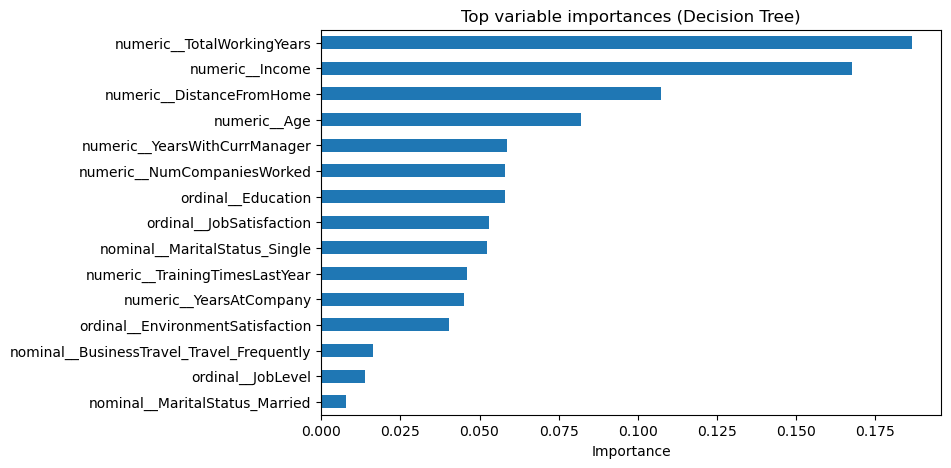

In [18]:
## Variable Importance: 
importances1 = pd.Series(
    best_tree1.feature_importances_,
    index = X_train_processed_df.columns).sort_values(ascending=False)
print(f'\nVariable Importance: {importances1}')
plt.figure(figsize=(8,5))
importances1.head(15).plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title("Top variable importances (Decision Tree)")
plt.xlabel("Importance")
plt.show()



In [19]:
### Look at two most important variables together ----

top_two1 = importances1.head(2).index.tolist()
print("\nTop two variables:", top_two1)


Top two variables: ['numeric__TotalWorkingYears', 'numeric__Income']


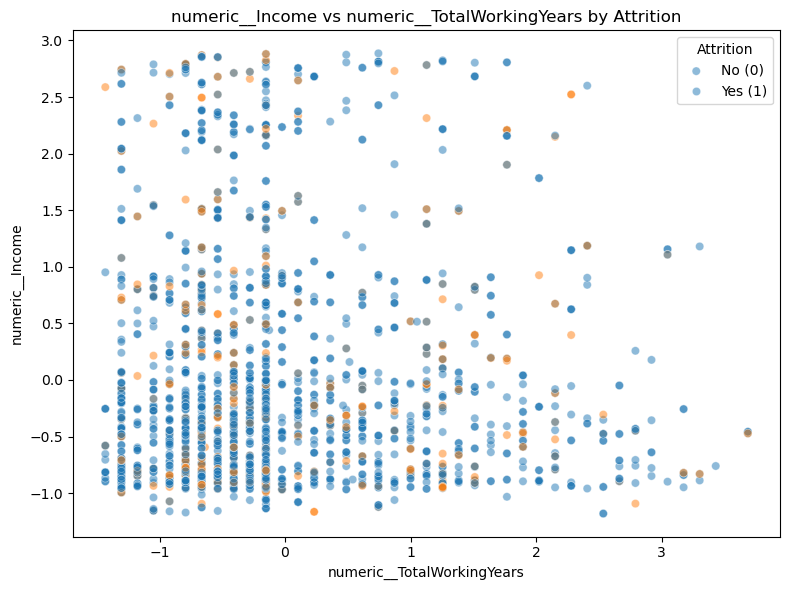

In [20]:
## create a dataset for plotting 
if len(top_two1) == 2:
    var_x1, var_y1 = top_two1
    data_two_plot1 = X_train_processed_df.copy()
    data_two_plot1['Attrition_lab'] = y_train
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data = data_two_plot1,
        x=var_x1,
        y=var_y1,
        hue="Attrition_lab",
        alpha=0.5
    )
    plt.title(f"{var_y1} vs {var_x1} by Attrition")
    plt.legend(title = 'Attrition' , labels = ['No (0)' , 'Yes (1)'])
    plt.tight_layout()
    plt.show()


In [21]:
## predictions and the final model evaulation on the test set 

probs_test1 = best_tree1.predict_proba(X_test_processed_df)
probs_true_test1 = probs_test1[:, true_idx1]
## get the ROC and the AUC for the test set 

test_fpr1 , test_tpr1 , test_thresholds1 = roc_curve(y_test, probs_true_test) 
test_auc_value1 = roc_auc_score(y_test, probs_true_test1)

print(f'\nTst ROC AUC for Attrition: {test_auc_value1}')


Tst ROC AUC for Attrition: 0.8290974072664213


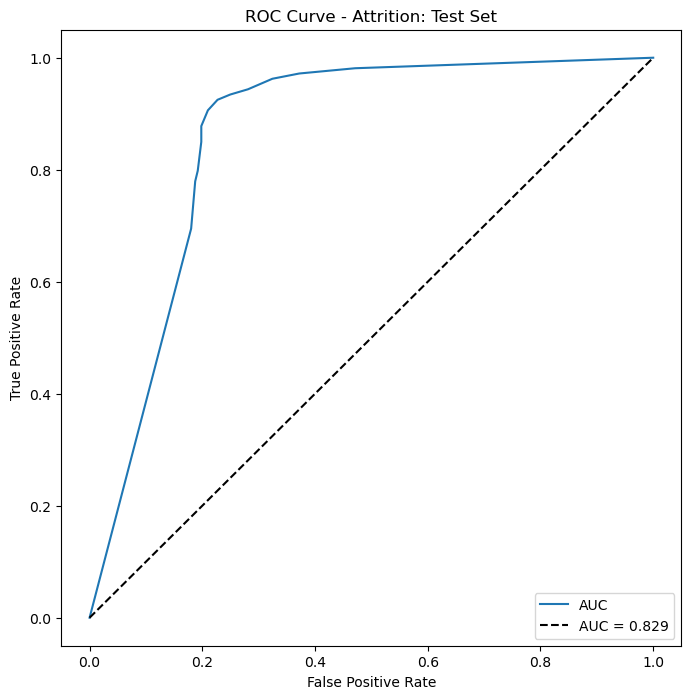

In [22]:
#### now we need to plot the ROC AUC curve

plt.figure(figsize=(8,8))
plt.plot(test_fpr1 , test_tpr1 , label = 'AUC')
plt.plot([0,1],[0,1], 'k--' , label=f"AUC = {test_auc_value1:.3f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Attrition: Test Set')
plt.legend(loc='lower right')
plt.show()


In [23]:
### Generate preditions at a 0.5 threshold 
y_pred_test1 = (probs_true_test1 > 0.5).astype(int)
accuracy_test1 = accuracy_score(y_test, y_pred_test)
recall_test1 = recall_score(y_test, y_pred_test)
precision_test1 = precision_score(y_test, y_pred_test)
f1_test1 = f1_score(y_test, y_pred_test)
print(f'Test Set -- Accuracy: {accuracy_test1} , Recall: {recall_test1} , Precision: {precision_test1} , f1: {f1_test1}')



Test Set -- Accuracy: 0.8087679516250945 , Recall: 0.9061032863849765 , Precision: 0.45305164319248825 , f1: 0.6040688575899843


In [24]:
cm_test1 = confusion_matrix(y_test, y_pred_test)
print(f'\nConfusion Matrix')
print(cm_test1)


Confusion Matrix
[[877 233]
 [ 20 193]]


In [25]:
cr_test1 = classification_report(y_test, y_pred_test , target_names = ['No Attrition (0)'  , 'Attrition (1)'])
print(f'\nClassification Report')
print(cr_test1)



Classification Report
                  precision    recall  f1-score   support

No Attrition (0)       0.98      0.79      0.87      1110
   Attrition (1)       0.45      0.91      0.60       213

        accuracy                           0.81      1323
       macro avg       0.72      0.85      0.74      1323
    weighted avg       0.89      0.81      0.83      1323



---

Simple Model 

In [45]:
pipe2 = Pipeline([
    ('tree' , DecisionTreeClassifier(random_state=random_seed))
])

param_grid2 = {
    'tree__max_depth' : [3,4],
    'tree__min_samples_leaf' :  [5,10,15,20,25,30],
    "tree__min_samples_split" : [10,20,30,40,50,60],
    'tree__max_leaf_nodes' : [12],
    'tree__ccp_alpha' : [0.0,0.001,0.005],
    'tree__criterion' : ['gini' , 'entropy']
}
grid2 = GridSearchCV(
    estimator=pipe2, 
    param_grid=param_grid2,
    scoring = 'roc_auc',
    cv = 10,
    n_jobs=-1
)

In [46]:
grid2.fit(X_train_processed_balanced_df , y_train_balanced)
print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV ROC AUC: {grid.best_score_:.4f}")

Best Parameters: {'ccp_alpha': np.float64(0.001)}
Best CV ROC AUC: 0.8431


In [47]:
### Extract best tree
best_tree2 = grid2.best_estimator_
best_dt2 = best_tree2.named_steps['tree'] 

print(f"\nTree Complexity:")
print(f"  Leaves: {best_dt2.get_n_leaves()}")
print(f"  Depth:  {best_dt2.get_depth()}")



Tree Complexity:
  Leaves: 12
  Depth:  4


In [49]:
### Evaluate on test set
true_idx2 = np.where(best_dt2.classes_ == 1)[0][0]

# Training metrics
train_probs2 = best_tree2.predict_proba(X_train_processed_balanced_df)[:, true_idx2]
train_auc2 = roc_auc_score(y_train_balanced, train_probs2)

# Test metrics
test_probs2 = best_tree2.predict_proba(X_test_processed_df)[:, true_idx2]
test_pred2 = (test_probs2 > 0.5).astype(int)

test_auc2 = roc_auc_score(y_test, test_probs2)
test_acc2 = accuracy_score(y_test, test_pred2)
test_recall2 = recall_score(y_test, test_pred2)
test_precision2 = precision_score(y_test, test_pred2)
test_f1 = f1_score(y_test, test_pred2)

print(f"\nPerformance:")
print(f"  Train AUC: {train_auc2:.4f}")
print(f"  Test AUC:  {test_auc2:.4f}")
print(f"  Gap:       {train_auc2 - test_auc2:.4f} (smaller = less overfitting)")
print(f"  Accuracy:  {test_acc2:.4f}")
print(f"  Recall:    {test_recall2:.1%}")
print(f"  Precision: {test_precision2:.1%}")
print(f"  f1 score:  {test_f1:.4f}")



Performance:
  Train AUC: 0.7577
  Test AUC:  0.6672
  Gap:       0.0904 (smaller = less overfitting)
  Accuracy:  0.6999
  Recall:    51.2%
  Precision: 27.1%
  f1 score:  0.3545


In [50]:
importance2 = pd.Series(
    best_dt2.feature_importances_,
    index = X_train_processed_balanced_df.columns).sort_values(ascending=False)
print('\nVariable Importance:')
print(importance2)


Variable Importance:
numeric__YearsWithCurrManager                0.369687
numeric__Age                                 0.157722
numeric__TotalWorkingYears                   0.117115
nominal__MaritalStatus_Single                0.083729
ordinal__JobLevel                            0.066466
ordinal__JobSatisfaction                     0.052579
ordinal__EnvironmentSatisfaction             0.046843
numeric__Income                              0.043910
numeric__DistanceFromHome                    0.036544
numeric__TrainingTimesLastYear               0.025405
ordinal__Education                           0.000000
numeric__NumCompaniesWorked                  0.000000
numeric__YearsAtCompany                      0.000000
nominal__Gender_Male                         0.000000
nominal__BusinessTravel_Travel_Frequently    0.000000
nominal__BusinessTravel_Travel_Rarely        0.000000
nominal__MaritalStatus_Married               0.000000
dtype: float64


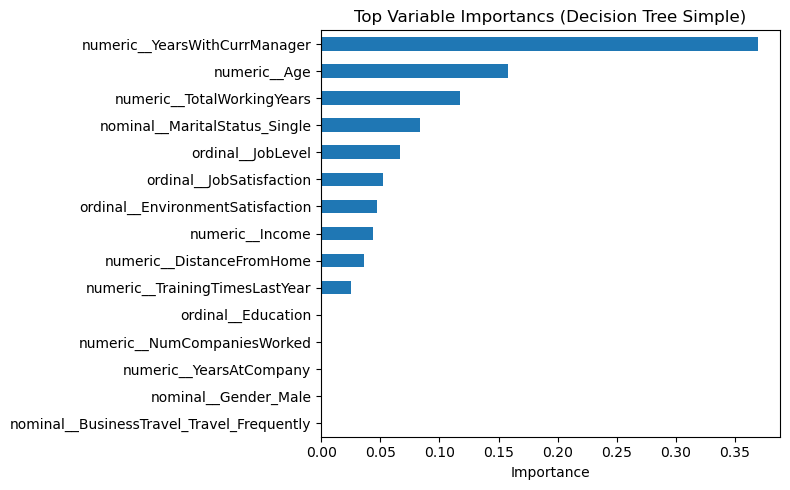

In [51]:
plt.figure(figsize=(8,5))
importance2.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top Variable Importancs (Decision Tree Simple)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

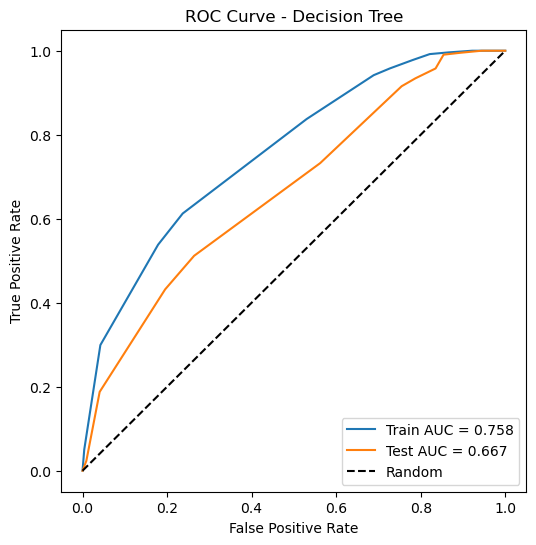

In [52]:
### ROC Curve (train vs test)
train_fpr2, train_tpr2, _ = roc_curve(y_train_balanced, train_probs2)
test_fpr2, test_tpr2, _ = roc_curve(y_test, test_probs2)

plt.figure(figsize=(6, 6))
plt.plot(train_fpr2, train_tpr2, label=f"Train AUC = {train_auc2:.3f}")
plt.plot(test_fpr2, test_tpr2, label=f"Test AUC = {test_auc2:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.show()

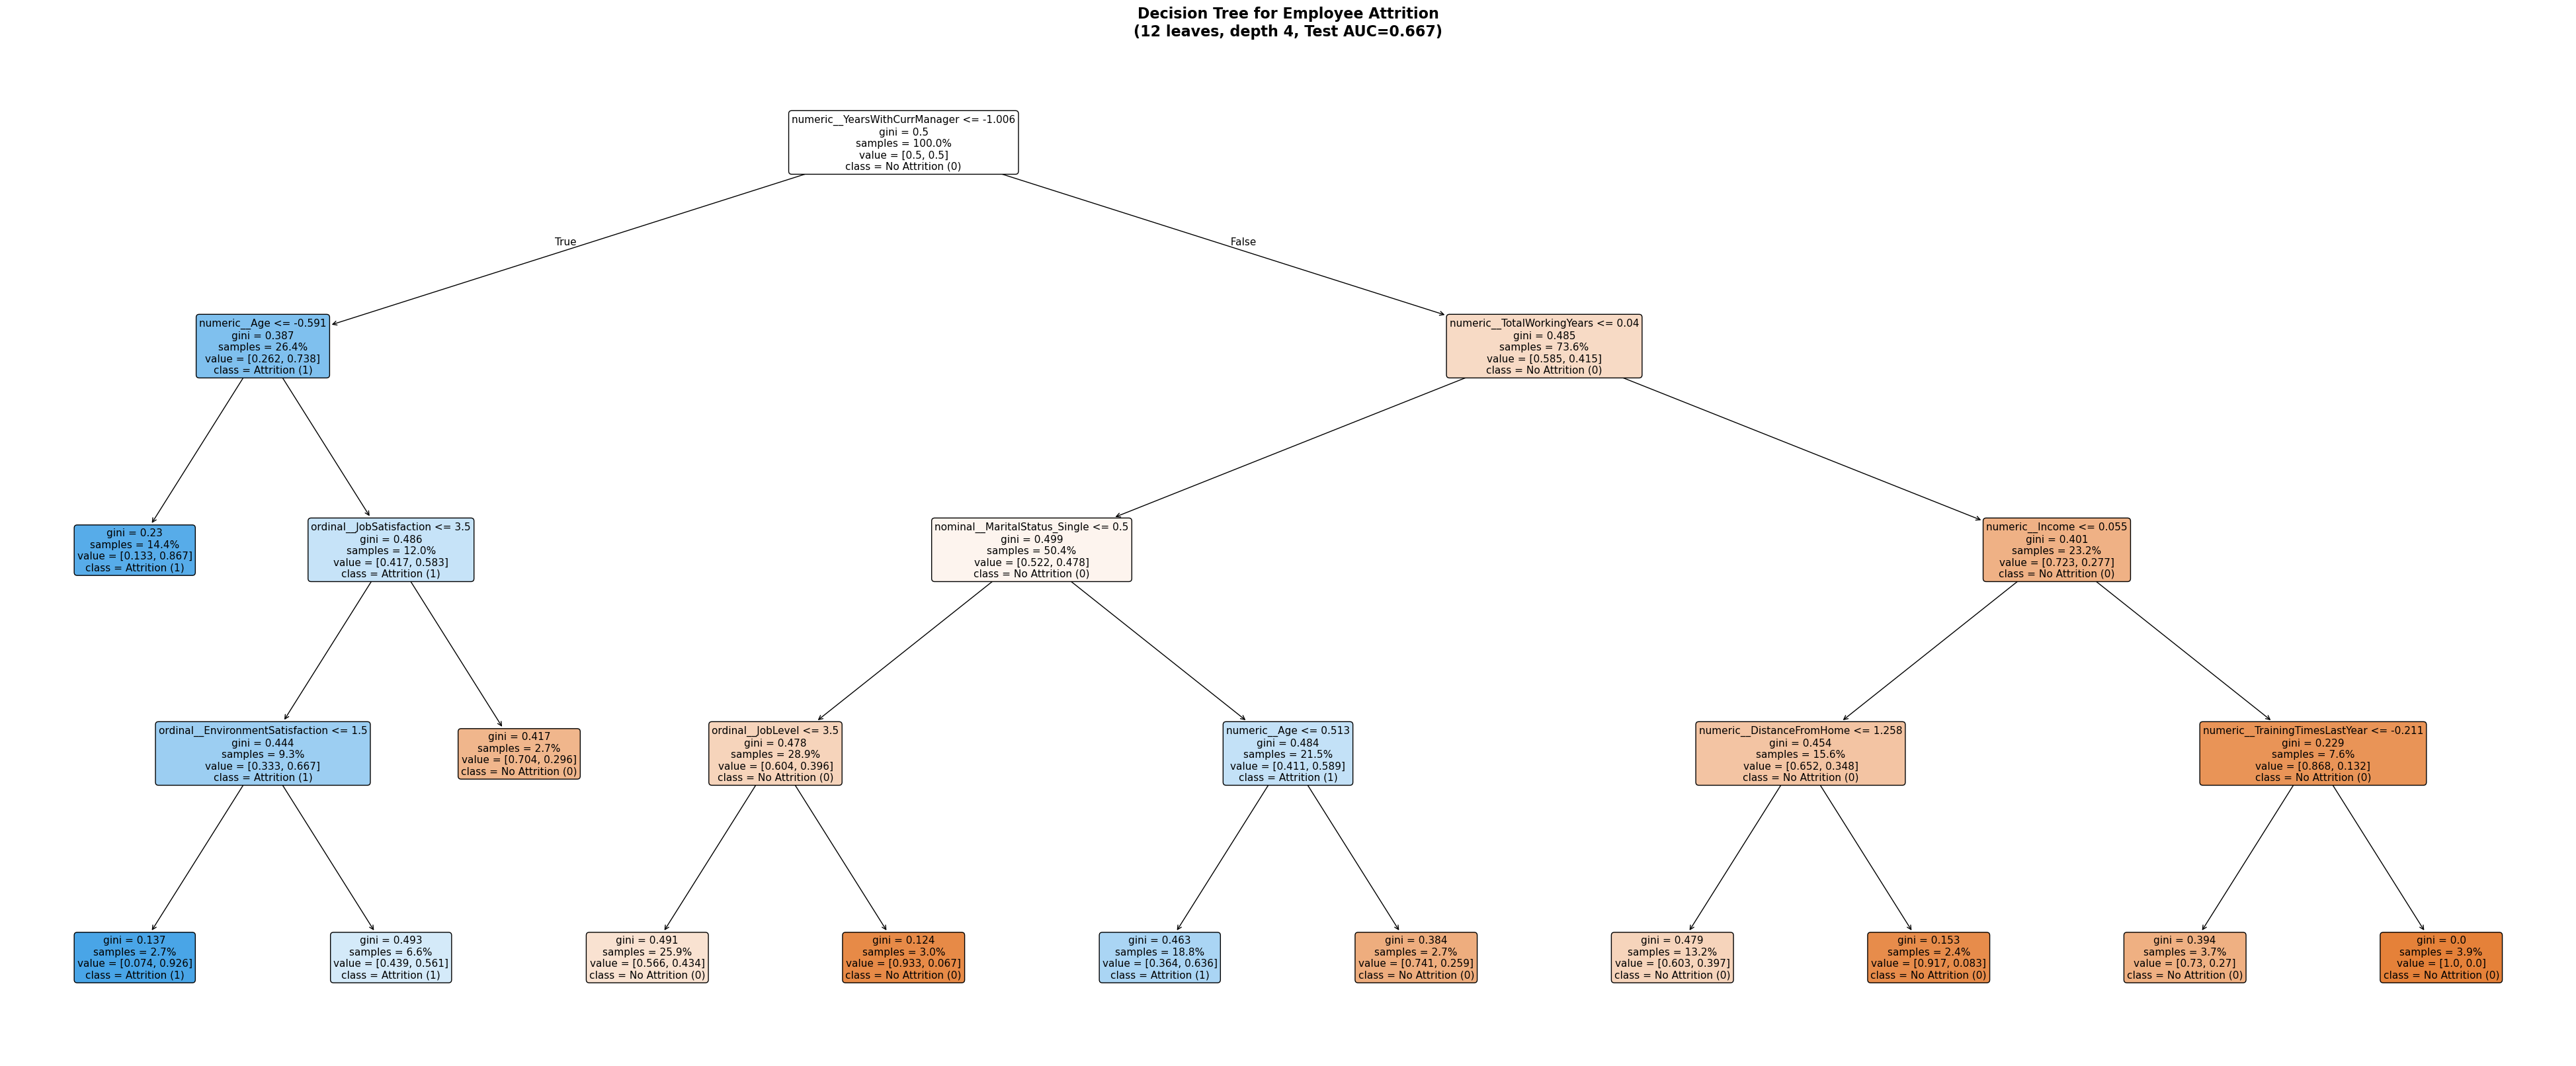

In [53]:
plt.figure(figsize=(50, 20))
plot_tree(
    best_dt2,
    feature_names=X_train_processed_balanced_df.columns.tolist(),
    class_names=['No Attrition (0)', 'Attrition (1)'],
    filled=True,
    rounded=True,
    fontsize=11,
    proportion=True  # Shows percentages instead of counts
)
plt.title(f'Decision Tree for Employee Attrition\n'
          f'({best_dt2.get_n_leaves()} leaves, depth {best_dt2.get_depth()}, Test AUC={test_auc2:.3f})', 
          fontsize=16, fontweight='bold')
plt.show()

---

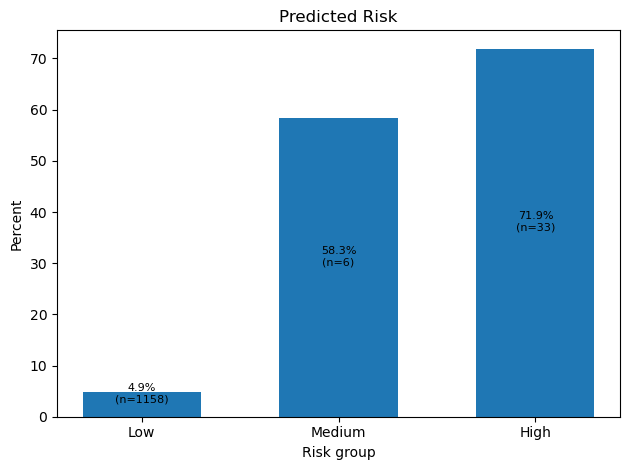

In [ ]:
results = pd.DataFrame({
    "Attrition_actual": y_test.values,   
    "Attrition_prob":  probs_true_test1        
})

def classify_risk(p):
    if p < 0.2:
        return "Low"
    elif p < 0.4:
        return "Medium"
    else:
        return "High"

results["risk_group"] = results["Attrition_prob"].apply(classify_risk)
band_summary = (
    results
    .groupby("risk_group")
    .agg(
        n_employees=("Attrition_actual", "size"),
        avg_predicted_risk=("Attrition_prob", "mean"),
        attrition_rate=("Attrition_actual", "mean")
    )
    .reset_index()
)
band_summary = band_summary.sort_values(by="avg_predicted_risk", ascending=True)

# Plot graph for risk ranges:
plot_df = band_summary.copy()
plot_df["avg_predicted_risk_pct"] = plot_df["avg_predicted_risk"] * 100

x = np.arange(len(plot_df))
width = 0.6  

fig, ax = plt.subplots()

# Avg predicted risk (%)
bars = ax.bar(x, plot_df["avg_predicted_risk_pct"], width, label="Avg predicted risk (%)")

ax.set_xticks(x)
ax.set_xticklabels(plot_df["risk_group"])
ax.set_ylabel("Percent")
ax.set_xlabel("Risk group")
ax.set_title("Predicted Risk")

# labels
for bar,(_,row) in zip(bars,plot_df.iterrows()):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, h/2,
        f"{h:.1f}%\n(n={int(row['n_employees'])})",
        ha="center",va="bottom",fontsize=8)

plt.tight_layout()
plt.show()
